# Lane Detection

**initial setup** - imports, constants, and setup

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
from numpy import ones, vstack
from numpy.linalg import lstsq
from evaluate.lane import LaneEval

COLOR = [0, 0, 255]
THICKNESS = 2

warnings.filterwarnings('ignore')

**general helper functions**

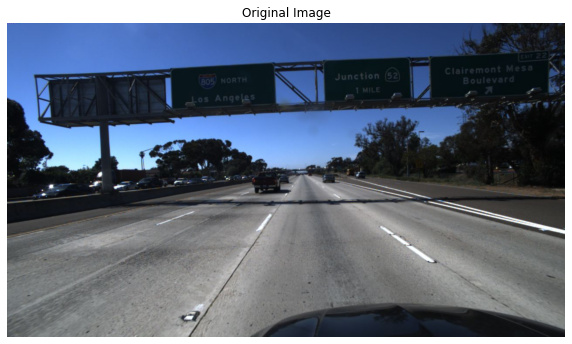

In [2]:
def show_image(img, title=''):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,15))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def get_image(clip_no):
    # Uncomment to use lane detection dataset

    # label_file = 'train_set/label_data_0313.json'
    # with open(label_file) as f:
    #     labels = json.load(f)
    
    # Choose which dataset to use
    path = f'benchmark_velocity_train/clips/{clip_no}/imgs/040.jpg'
    # path = f"train_set/{labels[clip_no-1]['raw_file']}"
    img = cv2.imread(path)
    return img
    
demo_img = get_image(12)
show_image(demo_img, 'Original Image')

**preprocessed image** - return gray scaled and blurred image

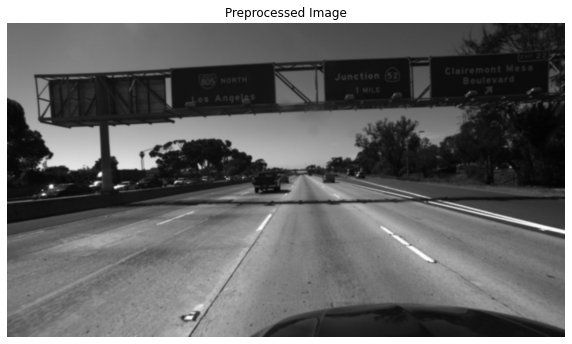

In [3]:
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

demo_img = preprocess(demo_img)
show_image(demo_img, 'Preprocessed Image')

**canny image** - run canny edge detection on image

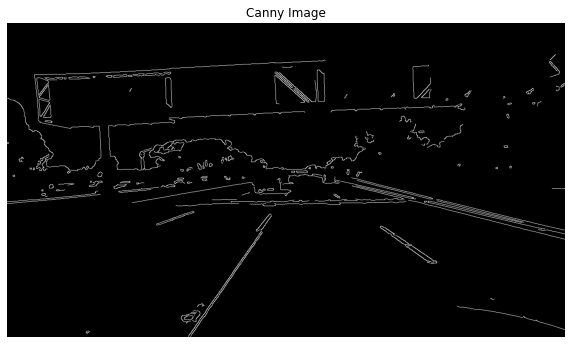

In [4]:
def canny(img):
    return cv2.Canny(img, 100, 200)

demo_img = canny(demo_img)
show_image(demo_img, 'Canny Image')

**region of interest** - crop image to lane region

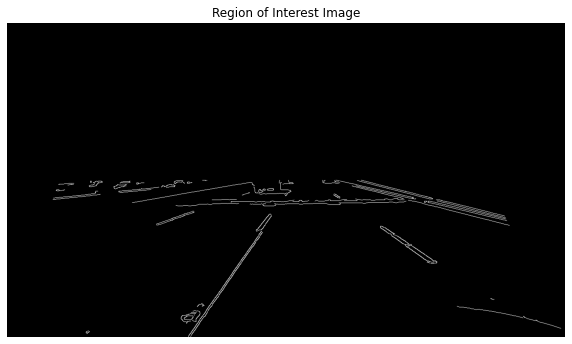

In [5]:
def region_of_interest(img):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """

    bot_left = [0, 720]
    bot_right = [1280, 720]
    top_left = [120, 360]
    top_right = [1100, 360]

    vertices = np.array([[bot_left, top_left,
                          top_right, bot_right]], dtype=np.int32)

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with
    # depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

demo_img = region_of_interest(demo_img)
show_image(demo_img, 'Region of Interest Image')

**hough line helper functions**

In [6]:
def extrapolate_line(img, gradient, x1, y1, filtered):
    c = y1 - (gradient * x1)
    top_val = 360
    top_point = (top_val - c) // gradient
    bot_point = (720 - c) // gradient

    y_bot_point = 720
    y_top_point = top_val

    if bot_point < 0:
        bot_point = 0
        y_bot_point = c
    elif bot_point > 1280:
        bot_point = 1280
        y_bot_point = (gradient * bot_point) + c

    if top_point < 0:
        top_point = 0
        y_top_point = c
    elif top_point > 1280:
        top_point = 1280
        y_top_point = (gradient * top_point) + c

    if (int(top_point) in range(600, 750)) and filtered:
        return [int(bot_point), int(y_bot_point), int(top_point), int(y_top_point)]
    elif not filtered:
        return [int(bot_point), int(y_bot_point), int(top_point), int(y_top_point)]

def get_edge_lines(lines_list):
    edge_lines = []
    for i in range(len(lines_list)):
        lines = lines_list[i]
        axis = int(i % 3 == 0)

        if len(lines) > 0:
            currMax = lines[0][axis]
            index = 0
            for i in range(len(lines)):
                line = lines[i]
                if line[axis] > currMax:
                    index = i
                    currMax = line[axis]

            edge_lines.append(lines[index])
        else:
            edge_lines.append(None)
        
    return edge_lines

**hough lines** - use hough transform to detect hough lines

In [7]:
def hough_lines(img, line_type):
    """
    `img` should be the output of a canny transform.

    Returns an image with hough lines drawn.
    """
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 20
    max_line_gap = 20

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]))
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)

    lanes = None
    h_samples = None

    if line_type == 'final':
        lanes, h_samples = filter_and_draw_lines(line_img, lines)
    elif line_type == 'hough':
        draw_lines(line_img, lines)
    elif line_type == 'extrapolated':
        draw_lines(line_img, lines, True)
    elif line_type == 'filtered':
        draw_lines(line_img, lines, True, True)

    return line_img, lanes, h_samples

**draw lines** - functions to produce lines on images

In [8]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_and_draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    filtered_lines = []
    try:
        for line in lines:
            if line.any():
                for x1, y1, x2, y2 in line:
                    gradient, intercept = np.polyfit((x1, x2), (y1, y2), 1)
                    filtered_lines.append(extrapolate_line(img, gradient, x1, y1, True))
    except:
        pass

    left_lines = [l for l in filtered_lines if l and l[0] == 0]
    right_lines = [l for l in filtered_lines if l and l[0] == 1280]
    bot_lines = [l for l in filtered_lines if l and 0 < l[0] < 1280]

    bot_left_filtered_lines = []
    bot_right_filtered_lines = []
    left_filtered_lines = []
    right_filtered_lines = []

    # for the lines on the bottom
    for i in range(0, 1152 + 1, 128):
        valid_lines = [l for l in bot_lines if i <= l[0] < i+128 and l[1] == 720]

        if valid_lines:
            valid_line = [int(coord) for coord in np.median(valid_lines, 0)]
            if valid_line[0] < 640:
                bot_left_filtered_lines.append(valid_line)
            else:
                bot_right_filtered_lines.append(valid_line)

    # lines on the left and the right sides
    for i in range(432, 576 + 1, 144):
        valid_left_lines = [l for l in left_lines if i <= l[1] < i+144 and 450 < l[1] < 600]
        valid_right_lines = [l for l in right_lines if i <= l[1] < i+144 and 450 < l[1] < 600]

        if valid_left_lines:
            valid_line = [int(coord) for coord in np.median(valid_left_lines, 0)]
            left_filtered_lines.append(valid_line)

        if valid_right_lines:
            valid_line = [int(coord) for coord in np.median(valid_right_lines, 0)]
            right_filtered_lines.append(valid_line)

    filtered_lines = [left_filtered_lines, bot_left_filtered_lines, bot_right_filtered_lines, right_filtered_lines]
    edge_lines = get_edge_lines(filtered_lines)

    for edge_line in edge_lines:
        if edge_line:
            cv2.line(img, (int(edge_line[0]), int(edge_line[1])),
                    (int(edge_line[2]), int(edge_line[3])), COLOR, 10)


    lanes, h_samples = formatData(edge_lines)
    return lanes, h_samples

def draw_lines(img, lines, extrapolated=False, filtered=False):
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if extrapolated:
                gradient, intercept = np.polyfit((x1, x2), (y1, y2), 1)
                l = extrapolate_line(img, gradient, x1, y1, filtered)
                if l:
                    cv2.line(img, (l[0], l[1]), (l[2], l[3]), COLOR, THICKNESS)
            else:
                cv2.line(img, (x1, y1), (x2, y2), COLOR, THICKNESS)
    except:
        pass

In [9]:
def formatData(lines):
    h_samples = [i for i in range(240, 711, 10)]
    lanes = []

    for l in lines:
        if l != None:
            x1, y1, x2, y2 = l
            gradient, intercept = np.polyfit((x1, x2), (y1, y2), 1)
            # y = mx + c
            c = y1 - (gradient * x1)
            lane = []

            for y in h_samples:
                if y < 360:
                    lane.append(-2)
                else:
                    x_val = (y - c) // gradient
                    lane.append(int(x_val))

            lanes.append(lane)

    return lanes, h_samples

## Demo

In [10]:
def demo(img):
    imgs = {'Preprocessed':None,'Canny':None,'Masked':None,
                'Hough Lines':None,'Extrapolated':None,'Filtered':None,'Final':None}
    
    imgs['Preprocessed'] = preprocess(img)
    imgs['Canny'] = canny(np.uint8(imgs['Preprocessed']))
    imgs['Masked'] = region_of_interest(imgs['Canny'])
    
    imgs['Hough Lines'] = weighted_img(hough_lines(imgs['Masked'], 'hough')[0], img)
    imgs['Extrapolated'] = weighted_img(hough_lines(imgs['Masked'], 'extrapolated')[0], img)
    imgs['Filtered'] = weighted_img(hough_lines(imgs['Masked'], 'filtered')[0], img)

    img_final, lanes, h_samples = hough_lines(imgs['Masked'], 'final')
    imgs['Final'] = weighted_img(img_final, img)

    if not os.path.exists('output'):
        print('creating output dir')
        os.mkdir('./output')

    return imgs

img = get_image(12)
imgs = demo(img)

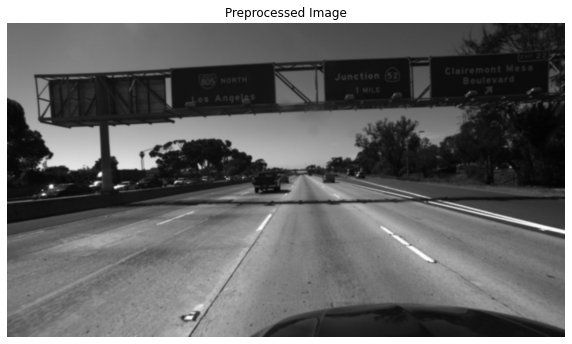

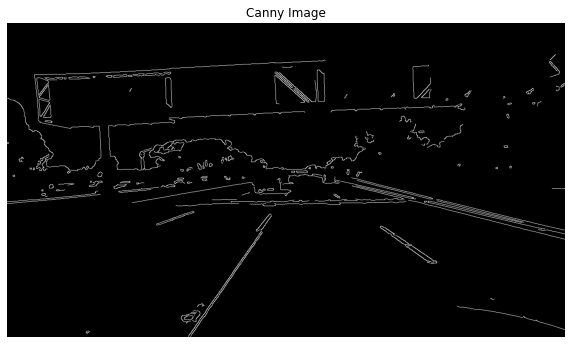

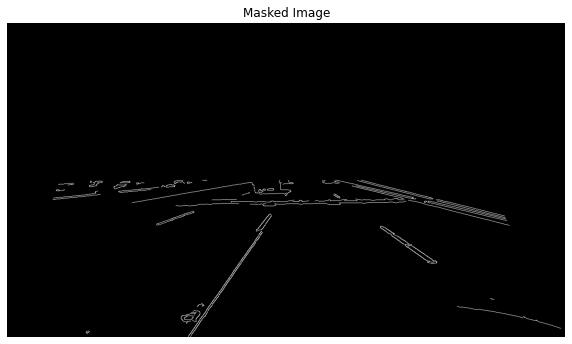

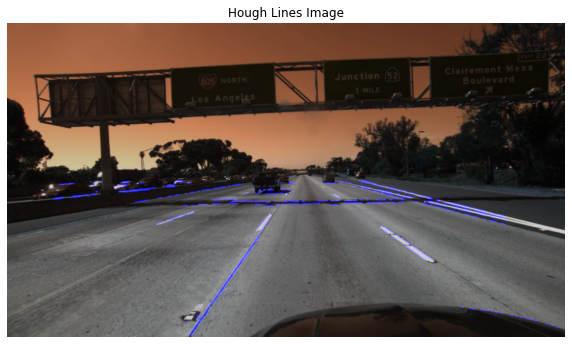

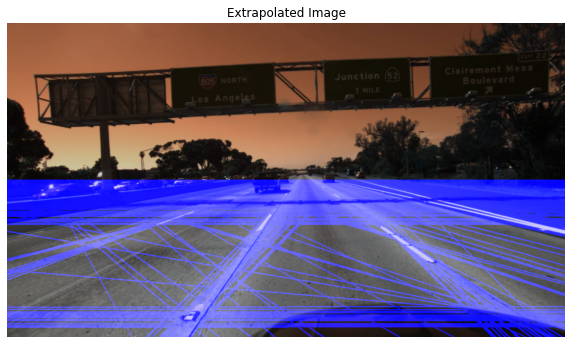

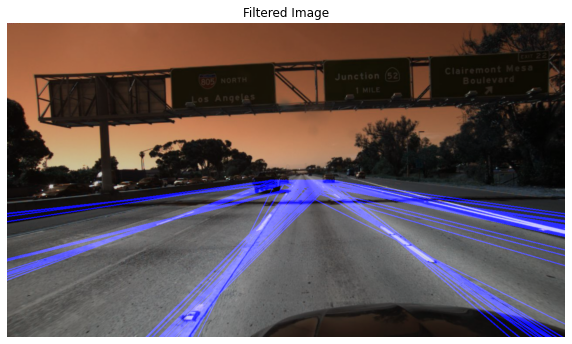

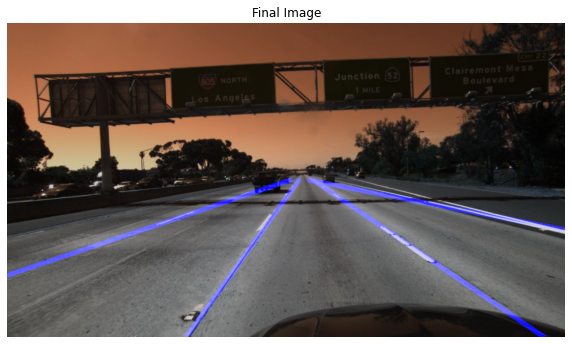

In [11]:
for img_stage in imgs:
    title = f'{img_stage} Image'
    show_image(imgs[img_stage], title)

## Evaluation

In [12]:
def run_evaluation():
    label_file = 'train_set/label_data_0313.json'

    with open(label_file) as f:
        labels = json.load(f)

    accuracies, fp_rates, fn_rates = [], [], []
    for label in labels:
        path = f"train_set/{label['raw_file']}"
        img = cv2.imread(path)
        gt = label['lanes']

        preprocessed_img = preprocess(img)
        canny_img = canny(np.uint8(preprocessed_img))
        masked_img = region_of_interest(canny_img)
        img_final, pred, h_samples = hough_lines(masked_img, 'final')

        accuracy, fp_rate, fn_rate = LaneEval.bench(pred, gt, h_samples)

        accuracies.append(accuracy)
        fp_rates.append(fp_rate)
        fn_rates.append(fn_rate)

    accuracy = sum(accuracies)/len(accuracies)
    fp_rate = sum(fp_rates)/len(fp_rates)
    fn_rate = sum(fn_rates)/len(fn_rates)
    
    return accuracy, fp_rate, fn_rate

accuracy, fp_rate, fn_rate = run_evaluation()
print(f'Accuracy: {accuracy}')
print(f'False positive rate: {fp_rate}')
print(f'False negative rate: {fn_rate}')

Accuracy: 0.09412176347095863
False positive rate: 0.5863657569395848
False negative rate: 0.9982505248425473
